### PreProcessing

In [2]:
import pandas as pd
import warnings

import numpy as np
warnings.filterwarnings("ignore", category=UserWarning)

# Load the dfset
df = pd.read_csv('dataset\AEP_hourly.csv')

# Convert 'Datetime' column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Sort the dfframe by datetime (if needed)
df = df.sort_values('Datetime')

# Display the first few rows of the dfset
print(df.head())


                Datetime   AEP_MW
2183 2004-10-01 01:00:00  12379.0
2184 2004-10-01 02:00:00  11935.0
2185 2004-10-01 03:00:00  11692.0
2186 2004-10-01 04:00:00  11597.0
2187 2004-10-01 05:00:00  11681.0


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 Datetime    0
AEP_MW      0
dtype: int64


In [4]:

from sklearn.preprocessing import MinMaxScaler

# Normalize 'AEP_MW' using Min-Max scaling
scaler = MinMaxScaler()
df['AEP_MW_scaled'] = scaler.fit_transform(df[['AEP_MW']])

# Display the scaled df
print("Scaled df:\n", df.head())


Scaled df:
                 Datetime   AEP_MW  AEP_MW_scaled
2183 2004-10-01 01:00:00  12379.0       0.173638
2184 2004-10-01 02:00:00  11935.0       0.146084
2185 2004-10-01 03:00:00  11692.0       0.131004
2186 2004-10-01 04:00:00  11597.0       0.125109
2187 2004-10-01 05:00:00  11681.0       0.130321


In [5]:
# Apply differencing to make the df stationary
df['AEP_MW_diff'] = df['AEP_MW'].diff()

# Alternatively, apply logarithmic transformation
df['AEP_MW_log'] = df['AEP_MW'].apply(lambda x: np.log(x) if x > 0 else 0)  # Apply log transformation, avoiding negative values

# Display the stationarized df
print("Stationarized df:\n", df.head())


Stationarized df:
                 Datetime   AEP_MW  AEP_MW_scaled  AEP_MW_diff  AEP_MW_log
2183 2004-10-01 01:00:00  12379.0       0.173638          NaN    9.423757
2184 2004-10-01 02:00:00  11935.0       0.146084       -444.0    9.387231
2185 2004-10-01 03:00:00  11692.0       0.131004       -243.0    9.366660
2186 2004-10-01 04:00:00  11597.0       0.125109        -95.0    9.358502
2187 2004-10-01 05:00:00  11681.0       0.130321         84.0    9.365719


### ARIMA

In [6]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity using Augmented Dickey-Fuller (ADF) test
def check_stationarity(df):
    result = adfuller(df)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Example: Check stationarity of 'AEP_MW' after differencing
check_stationarity(df['AEP_MW_diff'].dropna())

ADF Statistic: -44.96953846891294
p-value: 0.0
Critical Values:
   1%: -3.430403955763232
   5%: -2.861563847647993
   10%: -2.566782693260533


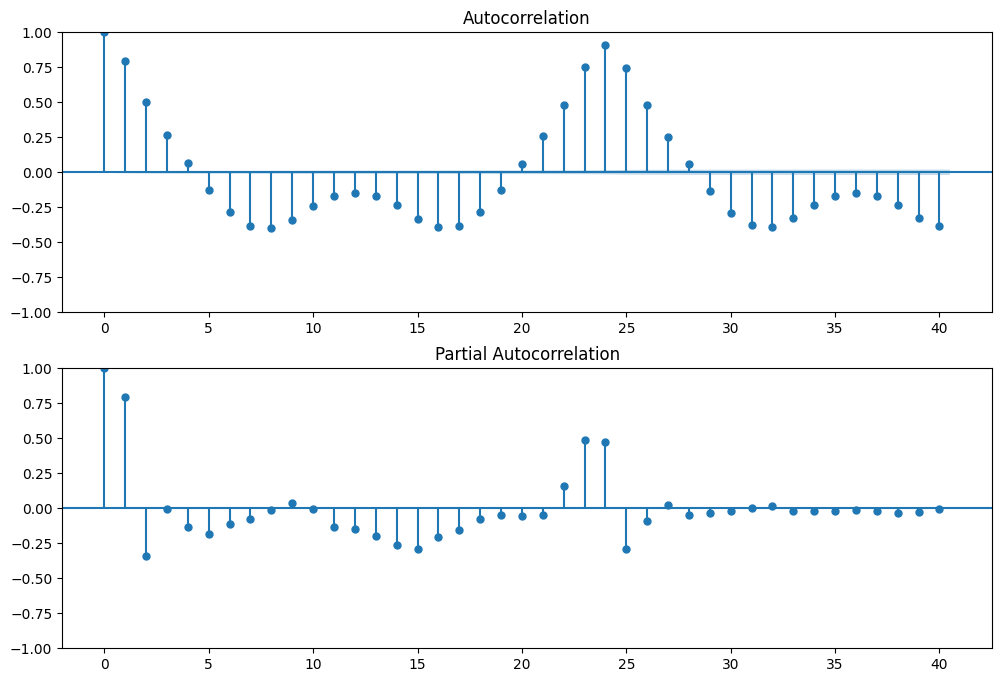

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for 'AEP_MW_diff' to identify p and q
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['AEP_MW_diff'].dropna(), lags=40, ax=ax1)
plot_pacf(df['AEP_MW_diff'].dropna(), lags=40, ax=ax2)
plt.show()


In [8]:
from statsmodels.tsa.arima.model import ARIMA

# Example: Fit ARIMA model with selected (p, d, q) parameters
# Replace p, d, q with your chosen values based on ACF/PACF analysis
p = 3  # Example: Autoregressive (AR) order
d = 4  # Example: Integrated (I) order (number of differences)
q = 2  # Example: Moving Average (MA) order

# Fit ARIMA model
model = ARIMA(df['AEP_MW'], order=(p, d, q))
result = model.fit()

# Display model summary
print(result.summary())


C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\statespace\mlemodel.py:3014: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


                               SARIMAX Results                                
Dep. Variable:                 AEP_MW   No. Observations:               121273
Model:                 ARIMA(3, 4, 2)   Log Likelihood                   0.000
Date:                Mon, 13 May 2024   AIC                             12.000
Time:                        20:25:17   BIC                             70.235
Sample:                             0   HQIC                            29.521
                             - 121273                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999   2.06e-08   4.86e+07      0.000       1.000       1.000
ar.L2          1.0000         -0       -inf      0.000       1.000       1.000
ar.L3         -1.0000   8.78e-09  -1.14e+08      0.0

C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\stattools.py:693: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import variation

# Get the predicted values from the ARIMA model
predicted_values = result.predict()

# Extract the actual values from your original dfset
actual_values = df['AEP_MW']

# Compute evaluation metrics
mae = mean_absolute_error(actual_values, predicted_values)
mse = mean_squared_error(actual_values, predicted_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
variation_=variation(actual_values)
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Display the computed metrics
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("coefficient of variation : ",variation_)


Mean Absolute Error (MAE): 2.5876129652110898e+22
Mean Squared Error (MSE): 1.5305248301236103e+45
Root Mean Squared Error (RMSE): 3.912192262815838e+22
Mean Absolute Percentage Error (MAPE): 1.778295211537986e+20
coefficient of variation :  0.16719159249434934


In [10]:
# Forecast using ARIMA model for future time points
future_steps = 24  # Number of future steps to forecast
arima_forecast = result.forecast(steps=future_steps)

C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### ARIMA

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,545 (17.75 KB)

 Trainable params: 4,545 (17.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 3s 757us/step - loss: 140014144.0000 - val_loss: 58275.1992
Epoch 2/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step - loss: 47911.4336 - val_loss: 34451.5430
Epoch 3/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 762us/step - loss: 33304.1055 - val_loss: 30101.8477
Epoch 4/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - loss: 27892.7109 - val_loss: 22286.7012
Epoch 5/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - loss: 19540.3203 - val_loss: 12631.0371
Epoch 6/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - loss: 10596.0020 - val_loss: 5863.4702
Epoch 7/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 749us/step - loss: 4633.0400 - val_loss: 2228.3140
Epoch 8/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - loss: 1820.5972 - val_loss: 1050.7428
Epoch 9/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 728us/step - loss: 1002.5586 - val_loss: 849.2914
Epoch 10/100
2426/2426 ━━━━━━━━━━━━━━━━━━━━ 2s 726us/step - loss: 861.6329 - val_loss: 775.1743
Epoch 11/100
2426

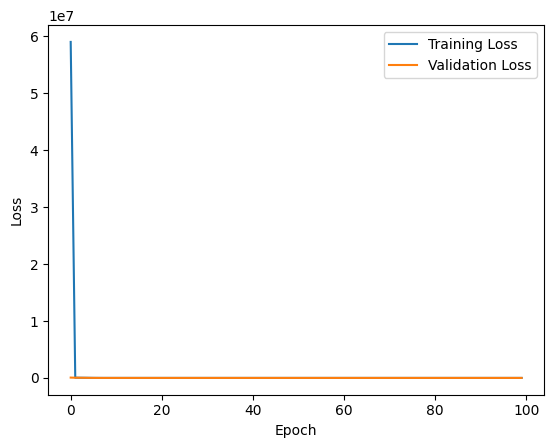

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Assuming 'AEP_MW' is the target variable
X = df.drop(columns=['Datetime'])  # Assuming 'Datetime' is not needed as a feature
y = df['AEP_MW']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the ANN model based on the best model parameters
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))  # First hidden layer
model.add(Dense(64, activation='relu'))  # Second hidden layer
model.add(Dense(1))  # Output layer

# Compile the model with specified learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse')  # Using Mean Squared Error (MSE) for regression

# Print model summary
model.summary()

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model on test dataQ
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}")

# Optionally, plot training history (loss vs. epochs)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

758/758 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step


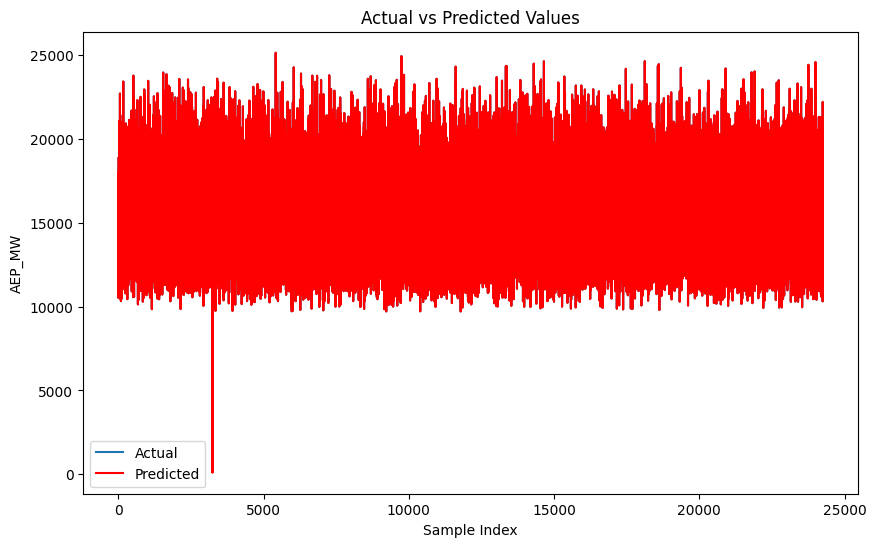

In [12]:
# Generate predictions using the trained model
predictions = model.predict(X_test_scaled)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual')
plt.plot(predictions, label='Predicted', color='r')
plt.title('Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()

### SARIMA

In [13]:
from statsmodels.tsa.stattools import adfuller

# Calculate seasonal difference (hourly data with daily seasonality)
df['AEP_MW_shifted'] = df['AEP_MW'].shift(24)  # Shift by 24 hours for daily seasonality
df['AEP_MW_seasonal_diff'] = df['AEP_MW'] - df['AEP_MW_shifted']

# Drop NaN values resulting from the shift
df.dropna(inplace=True)

# Perform Augmented Dickey-Fuller (ADF) test on the seasonal difference
result = adfuller(df['AEP_MW_seasonal_diff'])
print("ADF Statistic for Seasonal Differencing:", result[0])
print("p-value for Seasonal Differencing:", result[1])


ADF Statistic for Seasonal Differencing: -47.951808928769324
p-value for Seasonal Differencing: 0.0


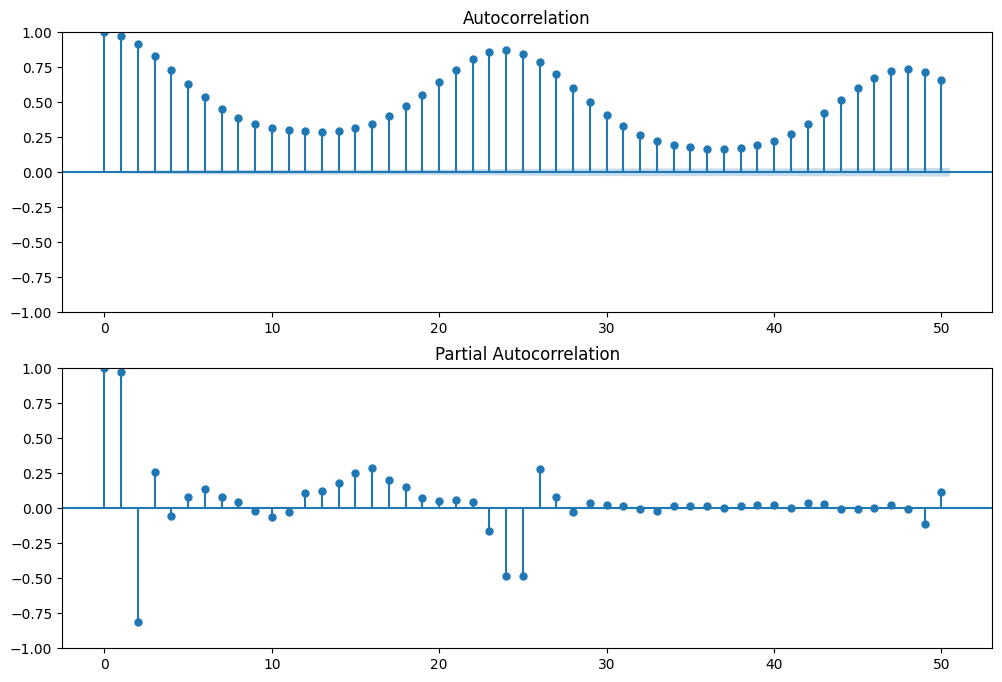

In [14]:
# Plot seasonal ACF and PACF to identify seasonal parameters (P, Q)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['AEP_MW'], lags=50, ax=ax1)  # Adjust 'lags' based on seasonal cycle
plot_pacf(df['AEP_MW'], lags=50, ax=ax2)  # Adjust 'lags' based on seasonal cycle
plt.show()


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define SARIMA model parameters (example)
order = (1, 1, 1)  # Non-seasonal parameters (p, d, q)
seasonal_order = (1, 1, 1, 24)  # Seasonal parameters (P, D, Q, seasonal_period)
# Use a subset of the data (e.g., first 1000 rows) for analysis
subset_data = df['AEP_MW'].iloc[:1000]

# Fit SARIMA model with subset data
sarima_model = SARIMAX(subset_data, order=order, seasonal_order=seasonal_order)
sarima_result = sarima_model.fit()


C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


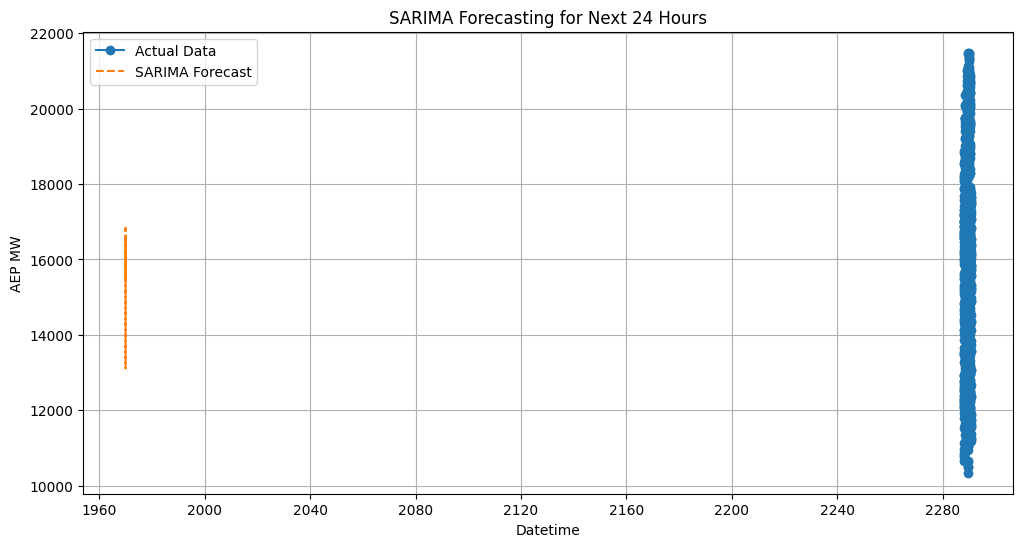

In [16]:
# Forecast future values
data_last_1000 = df.tail(1000)

forecast_steps = 24
forecast_sarima = sarima_result.forecast(steps=forecast_steps)

# Generate datetime index for forecast starting from the last timestamp in actual data
forecast_index = pd.date_range(start=data_last_1000.index[-1], periods=forecast_steps, freq='H')

# Plot actual data and SARIMA forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data_last_1000.index, data_last_1000['AEP_MW'], label='Actual Data', marker='o')
plt.plot(forecast_index, forecast_sarima, label='SARIMA Forecast', linestyle='--')

plt.xlabel('Datetime')
plt.ylabel('AEP MW')
plt.title('SARIMA Forecasting for Next 24 Hours')
plt.legend()
plt.grid(True)
plt.show()

### ETS

In [17]:
# Sample the data (last 24 hours for visualization)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data_last_24 = df.tail(24)

# Define a function to evaluate ETS models with different configurations
def evaluate_ets_model(data, trend, seasonal, seasonal_periods):
    model = ExponentialSmoothing(data, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
    ets_model = model.fit()
    return ets_model

# Try different configurations of ETS model and select based on AIC or BIC
best_model = None
best_aic = float('inf')
best_bic = float('inf')

# Define a range of parameters to search over
trend_options = ['add', 'mul']  # additive or multiplicative trend
seasonal_options = ['add', 'mul']  # additive or multiplicative seasonality
seasonal_period_options = [24]  # Seasonal period (e.g., hourly data)

In [19]:
for trend in trend_options:
    for seasonal in seasonal_options:
        for seasonal_period in seasonal_period_options:
            model = evaluate_ets_model(df['AEP_MW'], trend=trend, seasonal=seasonal, seasonal_periods=seasonal_period)
            aic = model.aic
            bic = model.bic
            if aic < best_aic:
                best_aic = aic
                best_model = model
            if bic < best_bic:
                best_bic = bic
                best_model = model

# Use the best model found based on AIC or BIC
print("Best ETS Model (based on AIC):", best_model.summary())

# Forecast future values with the best model
forecast_steps = 24
forecast = best_model.forecast(steps=forecast_steps)



C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Best ETS Model (based on AIC):                        ExponentialSmoothing Model Results                       
Dep. Variable:                   AEP_MW   No. Observations:               121249
Model:             ExponentialSmoothing   SSE                    10514438031.410
Optimized:                         True   AIC                        1378707.283
Trend:                   Multiplicative   BIC                        1378979.040
Seasonal:                Multiplicative   AICC                       1378707.299
Seasonal Periods:                    24   Date:                 Mon, 13 May 2024
Box-Cox:                          False   Time:                         20:38:34
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.7828571                alpha                

C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


### Prophet

In [20]:
data = df

C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.
22:20:43 - cmdstanpy - INFO - Chain [1] start processing
22:22:00 - cmdstanpy - INFO - Chain [1] done processing


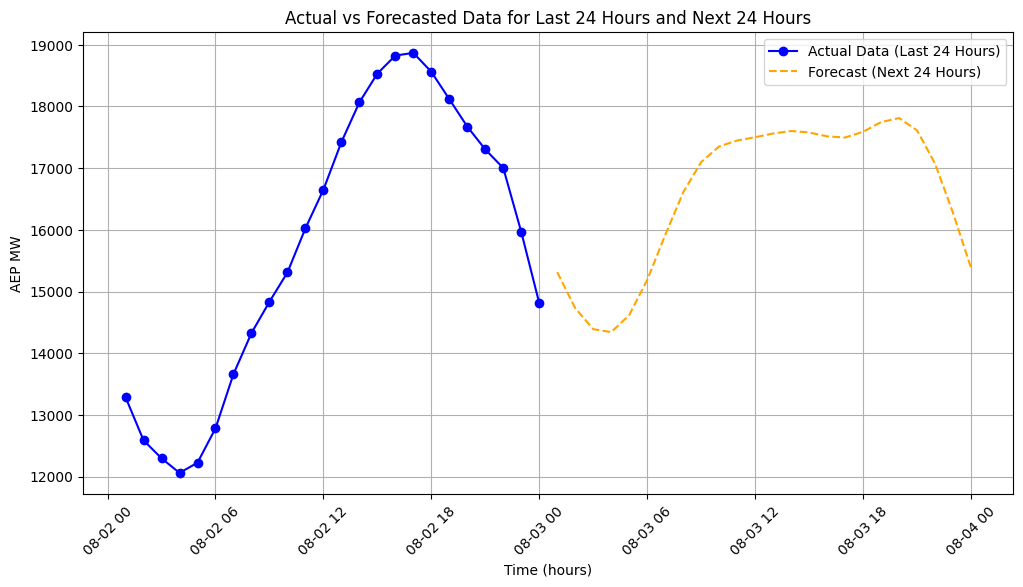

In [21]:
from prophet import Prophet

# Rename columns as required by Prophet ('ds' for datetime, 'y' for target variable)
data = data.rename(columns={'Datetime': 'ds', 'AEP_MW': 'y'})

# Filter data for the last 24 hours
last_24_hours = data.tail(24)

# Initialize Prophet model with potentially yearly, weekly, and daily seasonality
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

# Fit the model
prophet_model.fit(data)

# Forecast future values (next 24 hours)
future = prophet_model.make_future_dataframe(periods=24, freq='H')

# Predict values
forecast = prophet_model.predict(future)

# Filter forecast for the next 24 hours
forecast_next_24_hours = forecast.tail(24)

# Plot actual data and forecast
plt.figure(figsize=(12, 6))
# Plot actual data for the last 24 hours in blue
plt.plot(last_24_hours['ds'], last_24_hours['y'], label='Actual Data (Last 24 Hours)', marker='o', color='blue')

# Plot forecasted data for the next 24 hours in yellow
plt.plot(forecast_next_24_hours['ds'], forecast_next_24_hours['yhat'], label='Forecast (Next 24 Hours)', linestyle='--', color='orange')

plt.xlabel('Time (hours)')
plt.ylabel('AEP MW')
plt.title('Actual vs Forecasted Data for Last 24 Hours and Next 24 Hours')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.show()


### SVR

Test R^2 Score: 0.9999638807186654


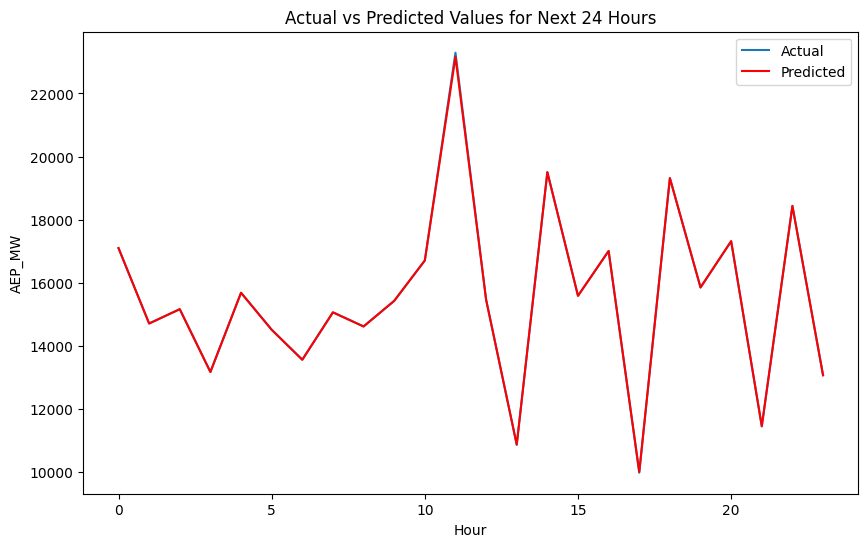

In [22]:
from sklearn.svm import SVR
# Assuming 'AEP_MW' is the target variable
X = df.drop(columns=['Datetime'])  # Assuming 'Datetime' is not needed as a feature
y = df['AEP_MW']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input features using Min-Max scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the SVR model
svr = SVR(kernel='rbf', C=100, gamma=0.1)  # Adjust hyperparameters as needed
svr.fit(X_train_scaled, y_train)

# Evaluate the model on test data
test_score = svr.score(X_test_scaled, y_test)
print(f"Test R^2 Score: {test_score}")

# Generate predictions for the next 24 hours
last_24_hours = X_test_scaled[-24:]  # Assuming X_test_scaled contains at least 24 hours of data
next_24_hours_predictions = svr.predict(last_24_hours)

# Plot actual vs predicted values for the next 24 hours
plt.figure(figsize=(10, 6))
plt.plot(np.arange(24), y_test[-24:], label='Actual')
plt.plot(np.arange(24), next_24_hours_predictions, label='Predicted', color='r')
plt.title('Actual vs Predicted Values for Next 24 Hours')
plt.xlabel('Hour')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()

### LSTM

C:\Users\mobiz\AppData\Local\Temp\ipykernel_25928\2068670072.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill missing values


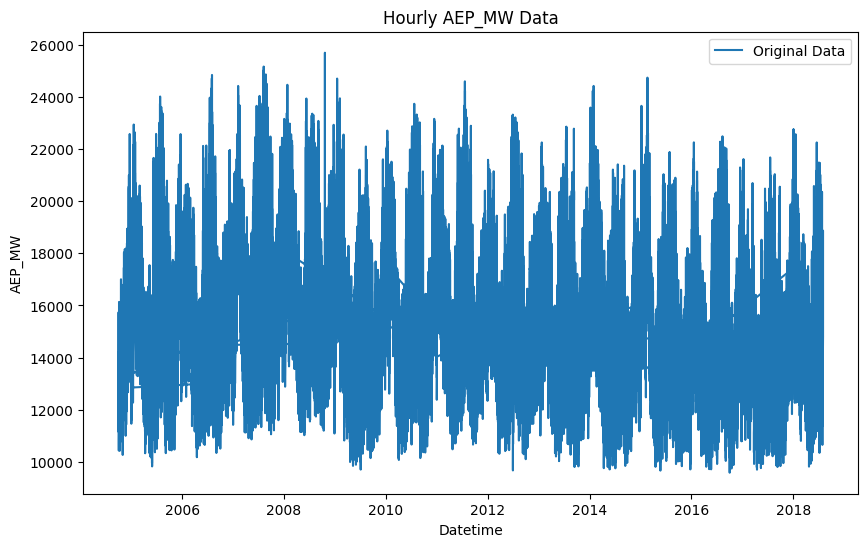

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('dataset/AEP_hourly.csv')

# Convert 'Datetime' column to datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as index
df.set_index('Datetime', inplace=True)

# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)  # Forward fill missing values

# Plot the original time series data
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['AEP_MW'], label='Original Data')
plt.title('Hourly AEP_MW Data')
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()

# Apply Min-Max scaling to normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df['AEP_MW_scaled'] = scaler.fit_transform(df['AEP_MW'].values.reshape(-1, 1))

# Prepare data for LSTM
def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        # Extract features (previous 'look_back' values)
        X.append(data[i:(i + look_back)])
        # Target value (next value after the 'look_back' window)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)


# Convert time series data into supervised learning problem
look_back = 24  # Number of hours to look back for forecasting
X, Y = create_dataset(df['AEP_MW_scaled'].values, look_back)

# Reshape input data into [samples, time steps, features]
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data into training and testing sets (considering only one time series)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]


Epoch 1/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0070 - val_loss: 8.2260e-04
Epoch 2/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 8.0198e-04 - val_loss: 7.1970e-04
Epoch 3/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.5405e-04 - val_loss: 6.2772e-04
Epoch 4/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.0124e-04 - val_loss: 5.8602e-04
Epoch 5/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 6.0172e-04 - val_loss: 5.8167e-04
Epoch 6/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.9427e-04 - val_loss: 6.0209e-04
Epoch 7/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.6160e-04 - val_loss: 5.4235e-04
Epoch 8/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.8809e-04 - val_loss: 5.7855e-04
Epoch 9/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.5426e-04 - val_loss: 5.3549e-04
Epoch 10/100
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.5276e-04 - val_loss: 5.4143e-04
Epoch 11/100
1516/1516 ━━━━━━━━━━

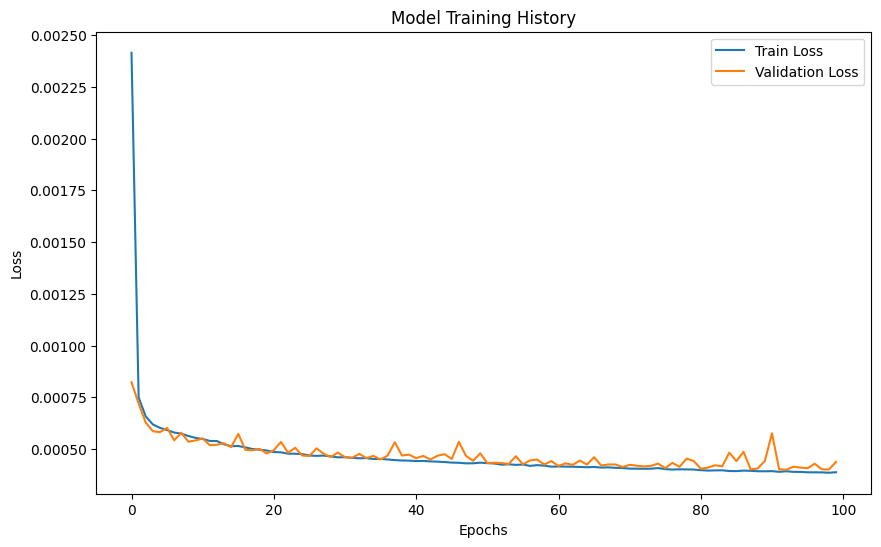

In [32]:
# Build LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit the model
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test), verbose=1)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


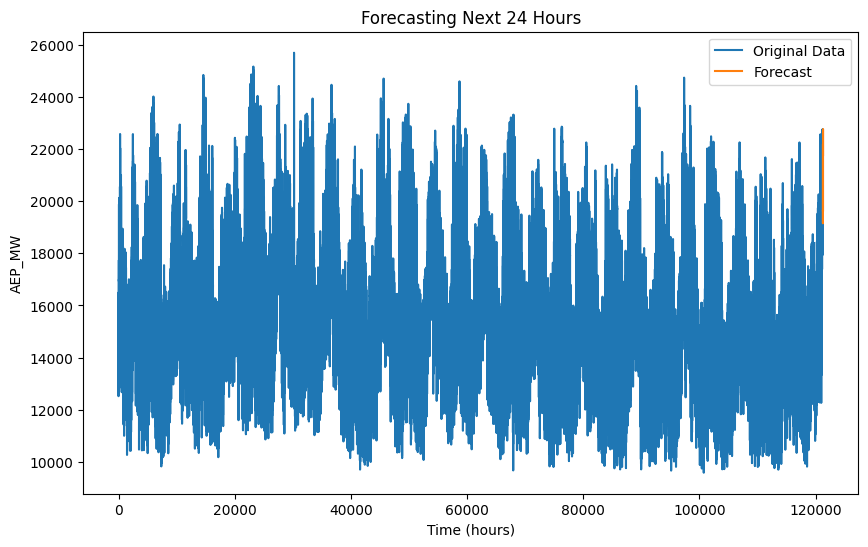

In [33]:
# Use the model to forecast next 24 hours
forecast_period = 24
forecast_input = df['AEP_MW_scaled'].values[-look_back:]  # Last look_back values from original data

forecast = []

for _ in range(forecast_period):
    # Reshape input for prediction
    x_input = np.array(forecast_input[-look_back:]).reshape((1, 1, look_back))
    # Make prediction
    yhat = model.predict(x_input, verbose=0)
    # Append prediction to forecast list
    forecast.append(yhat[0, 0])
    # Update input for next prediction
    forecast_input = np.append(forecast_input, yhat)

# Inverse transform forecasted values to original scale
forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

# Plot forecasted values
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(df['AEP_MW'])), df['AEP_MW'], label='Original Data')
plt.plot(np.arange(len(df['AEP_MW']), len(df['AEP_MW']) + forecast_period), forecast, label='Forecast')
plt.title('Forecasting Next 24 Hours')
plt.xlabel('Time (hours)')
plt.ylabel('AEP_MW')
plt.legend()
plt.show()


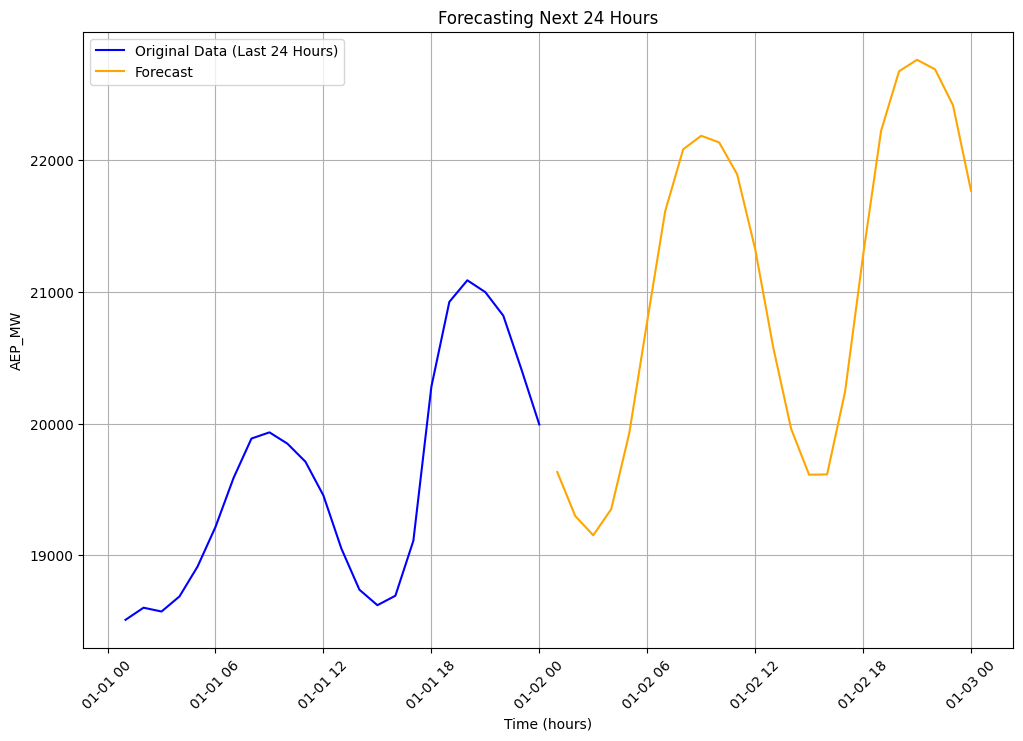

In [34]:
# Plot forecasted values along with original data
plt.figure(figsize=(12, 8))

# Plot original data (last 24 hours)
plt.plot(df.index[-24:], df['AEP_MW'][-24:], label='Original Data (Last 24 Hours)', color='blue')

# Plot forecasted values (next 24 hours)
forecast_index = pd.date_range(start=df.index[-1], periods=forecast_period+1, freq='H')[1:]  # Generate datetime index for forecasted period
plt.plot(forecast_index, forecast, label='Forecast', color='orange')

plt.title('Forecasting Next 24 Hours')
plt.xlabel('Time (hours)')
plt.ylabel('AEP_MW')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


### Hybrid Model

In [39]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset (replace 'your_dataset.csv' with your actual dataset path)
df = pd.read_csv('dataset/AEP_hourly.csv')

# Convert Datetime column to datetime format
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df.sort_index(inplace=True)

p = 5  # Example: Autoregressive (AR) order
d = 1  # Example: Integrated (I) order (number of differences)
q = 0  # Example: Moving Average (MA) order

# Fit ARIMA model to the dataset
arima_order = (p, d, q)  # Example ARIMA parameters (p, d, q)
model_arima = ARIMA(df['AEP_MW'], order=arima_order)
arima_results = model_arima.fit()

# Forecast using ARIMA model for future time points
future_steps = 24  # Number of future steps to forecast
arima_forecast = arima_results.forecast(steps=future_steps)

# Convert arima_forecast to a NumPy array
arima_forecast_np = arima_forecast.values

# Calculate residuals
actual_values = df['AEP_MW'].values
residuals = actual_values[-future_steps:] - arima_forecast_np

# Use ARIMA forecast as input features (X) and residuals as target (y) for ANN
X = arima_forecast_np.reshape(-1, 1)  # Reshape to 2D array for compatibility with scaler
y = residuals.reshape(-1, 1)  # Reshape to 2D array for compatibility with scaler

# Normalize input features (X) and target (y) using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Define and train a more complex ANN model
model_ann = Sequential([
    Dense(128, activation='relu', input_shape=(1,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer (single neuron for predicting residuals)
])

model_ann.compile(optimizer='adam', loss='mean_squared_error')
model_ann.fit(X_scaled, y_scaled, epochs=100, batch_size=32, verbose=0)  # Increased epochs and batch size

# Make predictions using the trained ANN
ann_predictions_scaled = model_ann.predict(X_scaled)

# Inverse scaling to get final predictions (residuals)
final_residuals = scaler_y.inverse_transform(ann_predictions_scaled)

# Generate corrected forecasts by adding final_residuals to arima_forecast_np
corrected_forecasts = arima_forecast_np + final_residuals.flatten()

# Calculate R-squared (coefficient of determination)
r2 = r2_score(actual_values[-future_steps:], corrected_forecasts)

print(f"Improved R-squared (R2) of Corrected Forecasts: {r2:.4f}")



C:\Users\mobiz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Improved R-squared (R2) of Corrected Forecasts: 0.5332
